In [1]:
pip install ucimlrepo

Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
cdc_diabetes_health_indicators = fetch_ucirepo(id=891) 
  
# data (as pandas dataframes, changed to numpy) 
x = cdc_diabetes_health_indicators.data.features.values
y = cdc_diabetes_health_indicators.data.targets.values
  
# to print metadata:
#print(cdc_diabetes_health_indicators.metadata) 
  
# to print variable information:
print(cdc_diabetes_health_indicators.variables) 

                    name     role     type      demographic  \
0                     ID       ID  Integer             None   
1        Diabetes_binary   Target   Binary             None   
2                 HighBP  Feature   Binary             None   
3               HighChol  Feature   Binary             None   
4              CholCheck  Feature   Binary             None   
5                    BMI  Feature  Integer             None   
6                 Smoker  Feature   Binary             None   
7                 Stroke  Feature   Binary             None   
8   HeartDiseaseorAttack  Feature   Binary             None   
9           PhysActivity  Feature   Binary             None   
10                Fruits  Feature   Binary             None   
11               Veggies  Feature   Binary             None   
12     HvyAlcoholConsump  Feature   Binary             None   
13         AnyHealthcare  Feature   Binary             None   
14           NoDocbcCost  Feature   Binary             

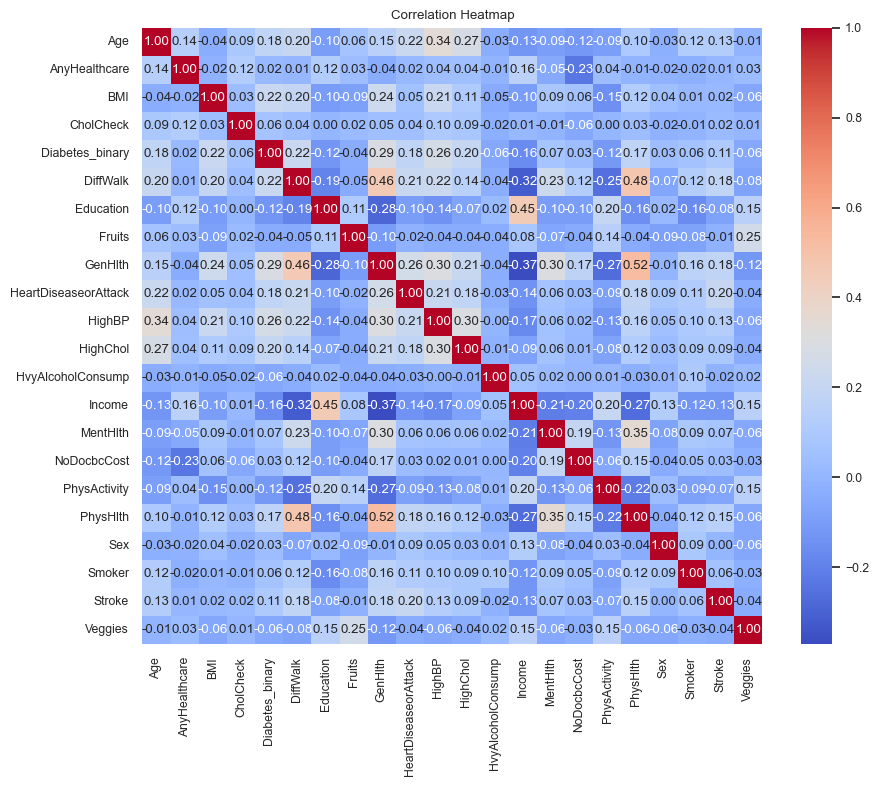

In [3]:
import pandas as pd
import seaborn as sns

# get data as a dataframe
x_df = cdc_diabetes_health_indicators.data.features
y_df = cdc_diabetes_health_indicators.data.targets
df = pd.concat([x_df, y_df], axis=1)

# calculate correlation matrix
correlation_matrix = df.corr()

# get correlations with the target variable and select if they are over a certain minimum correlation
min_correlation = 0.0 #0.0 does nothing, can increase to shrink table
correlation_with_target = correlation_matrix['Diabetes_binary']
selected_features = correlation_with_target[correlation_with_target.abs() > min_correlation].index

plt.figure(figsize=(10, 8))
sns.set(font_scale=0.8)
sns.heatmap(df[selected_features.union(['Diabetes_binary'])].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

#resetting to not impact future charts
sns.reset_defaults()

In [4]:
y = y.ravel() #makes y a 1D array instead of column vector

model = LogisticRegression(solver='liblinear', C=1, random_state=0).fit(x, y)

print("Logistic Regression Coefficients:")
features = []
coefficients = model.coef_[0] #get the LR coefficient for each variable
for i in range(21):
    feature = cdc_diabetes_health_indicators.variables['name'][i+2]
    if feature != 'Diabetes_binary':
        print(f"{feature}: {coefficients[i]:.5f}")
        features.append(feature)

Logistic Regression Coefficients:
HighBP: 0.75943
HighChol: 0.57800
CholCheck: 1.18039
BMI: 0.06039
Smoker: -0.01113
Stroke: 0.13348
HeartDiseaseorAttack: 0.22462
PhysActivity: -0.05387
Fruits: -0.04958
Veggies: -0.03382
HvyAlcoholConsump: -0.76635
AnyHealthcare: 0.07852
NoDocbcCost: 0.01349
GenHlth: 0.53218
MentHlth: -0.00369
PhysHlth: -0.00730
DiffWalk: 0.12284
Sex: 0.25614
Age: 0.12222
Education: -0.03410
Income: -0.05217


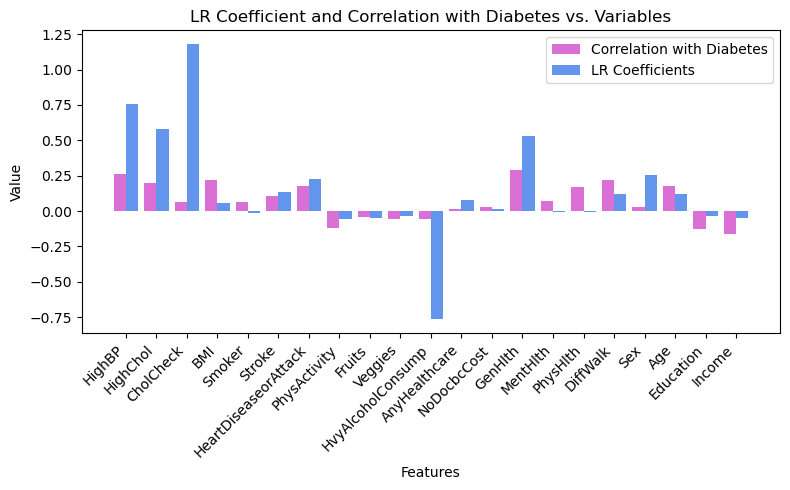

In [5]:
correlations = []
for feature, correlation in correlation_with_target.items():
    if feature != 'Diabetes_binary':
        correlations.append(correlation)

width = 0.4
offset = np.arange(len(features))

plt.figure(figsize=(8, 5))
plt.bar(features, 0)
plt.bar(offset - width/2, correlations, width, color='orchid', label='Correlation with Diabetes')
plt.bar(offset + width/2, coefficients, width, color='cornflowerblue', label='LR Coefficients')
plt.xlabel('Features')
plt.ylabel('Value')
plt.title('LR Coefficient and Correlation with Diabetes vs. Variables')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.legend()
plt.grid(False)

plt.show()

Logistic Regression Model Accuracy: 0.8635564490696941


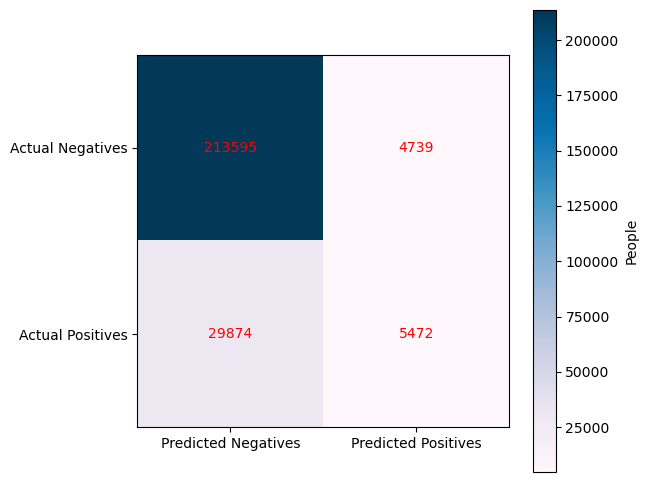

In [6]:
accuracy = model.score(x, y) #calculates accuracy of data that was used for training the model (as opposed to CV)
print(f"Logistic Regression Model Accuracy: {accuracy}")

threshold = 0.5
predicted_probabilities = model.predict_proba(x)[:, 1] #gets the predicted probabilities of diabetes for each patient
custom_predictions = (predicted_probabilities >= threshold).astype(int) #if predicted probability is greater than threshold, it is 1 (diabetic), otherwise, 0 (healthy)

cm = confusion_matrix(y, custom_predictions)
#cm = confusion_matrix(y, model.predict(x))  #automatically sets to 0.5, can use if not choosing a different threshold value

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(cm, cmap='PuBu')
ax.grid(False)
ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted Negatives', 'Predicted Positives'))
ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual Negatives', 'Actual Positives'))
ax.set_ylim(1.5, -0.5)
for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', color='red')

cbar = plt.colorbar(im)
cbar.set_label('People') 

plt.show()

In [7]:
from sklearn.model_selection import cross_val_score, StratifiedKFold

k = 5 #dataset split into 10 and one set left out each time
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)

cv_scores = cross_val_score(model, x, y, cv=cv, scoring='accuracy') #the scores are TPs & TNs over all predictions
print("Cross-validated accuracy scores for each fold:", cv_scores)

print("Average accuracy:", cv_scores.mean())

Cross-validated accuracy scores for each fold: [0.86398218 0.86295727 0.86390334 0.86345002 0.86313466]
Average accuracy: 0.8634854935351625


In [8]:
new_threshold = 0.4

k = 5
cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=0)

# Function to predict based on the new threshold
def predict_with_threshold(model, x, threshold):
    probas = model.predict_proba(x)[:, 1]  # Probabilities of positive class
    predictions = np.where(probas >= threshold, 1, 0)
    return predictions

# CV with new threshold
cv_scores = []
for train_index, test_index in cv.split(x, y):
    x_train, x_test = x[train_index], x[test_index]
    y_train, y_test = y[train_index], y[test_index]

    model.fit(x_train, y_train)
    y_pred = predict_with_threshold(model, x_test, new_threshold)

    accuracy = np.mean(y_pred == y_test)
    cv_scores.append(accuracy)

print("Cross-validated accuracy scores for each fold:", cv_scores)
print("Average accuracy:", np.mean(cv_scores))

Cross-validated accuracy scores for each fold: [0.8593700725323242, 0.8575961841690318, 0.8587196467991169, 0.8580495111952066, 0.8578524124881741]
Average accuracy: 0.8583175654367707


In [9]:
#to input new data and predict diabetes:
#to know what to input, use print(cdc_diabetes_health_indicators.variables) or go back up to first code block
#sample data below, new data would go in this array
new_person = np.array([1, 1, 1, 40, 1, 0, 0, 0, 0, 1, 0, 1, 0, 5, 18, 15, 1, 0, 9, 4, 3])
prediction = model.predict(new_person.reshape(1, -1))
if (prediction == 1):
    print("Prediction: Diabetic/Pre-diabetic")
else:
    print("Prediction: Healthy")

Prediction: Diabetic/Pre-diabetic
